# UV TRNU.CSN - Data and Machine Learning
## Unsupervised learning - TP Clustering - 2025

Christelle Garnier

### Aim of the TP

The aim of this practical work is:
- to perform clustering on data in order to automatically create categories by leveraging the classes and functions provided by the `Scikit-Learn` and `SciPy` libraries. 
- The methods to be implemented and tested are hierarchical agglomerative clustering and K-means algorithms. 


### Dataset 'hotels.csv'

The work consists of performing a clustering on the data contained in the file 'hotels.csv' available on MyLearningSpace. 

Start by looking at the file. It contains information about a set of hotels: NOM (name), PAYS (country), ETOILE (number of stars), CONFORT (comfort rating), CHAMBRE (number of rooms), CUISINE (food rating), SPORT (sport rating), PLAGE (beach rating), PRIX (price per night in euros).

The objective is to automatically group hotels of similar standing. The clustering can  identify several categories of hotels, which will be compared with the star-based classification.

### Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### 1. Reading the Data

1. Load the file 'hotels.csv' using `read_csv()` from the `pandas` library. Check the import by using the methods and attributes available for the `DataFrame` class, such as `info()`, `describe()`, `shape`, and `head()`.

1. Decide which variables to keep for clustering and store the corresponding columns separately so that the values of these variables can be retrieved later. In particular, you will need to name the hotels in graphical representations of the clusters.

1. Remove the unused columns with the `drop()` method of the `DataFrame` class.

1. Store the names of the remaining columns using the `columns` attribute of the `DataFrame` class so that the names of the variables/features used for clustering can be retrieved later. 

In [40]:
# 1. Load the dataset
data = pd.read_csv('hotels.csv')
data.head()

,NOM,PAYS,ETOILE,CONFORT,CHAMBRE,CUISINE,SPORT,PLAGE,PRIX
0,Appolpon,Grece,1,4,56,2,0,8,390
1,Caravel,Grece,4,7,471,7,6,5,468
2,Christina,Grece,2,7,93,3,0,5,427
3,Economy,Grece,1,3,56,1,0,8,369
4,EdenBeach,Grece,1,4,286,3,4,7,499


In [41]:
# 2. Decide to remove the non-numeric columns

# 3. Remove the non-numeric columns
data = data.drop(columns=['NOM', 'PAYS', 'ETOILE'])
# print(data)

# 4. Store the column names
data_columns = data.columns
print(data_columns)

Index(['CONFORT', 'CHAMBRE', 'CUISINE', 'SPORT', 'PLAGE', 'PRIX'], dtype='object')


### 2. Exploring the Data

Once the data has been imported and selected, begin with a preliminary analysis to identify relationships between the variables.

1. Compute the correlation coefficients between all pairs of numerical variables using the `corr()` method of the `DataFrame` class and visualize the correlation matrix as a heatmap using the `heatmap()` function from the `seaborn` library. 

1. Identify which variables are the most strongly correlated (positively and negatively), and which ones show the weakest correlations.

Text(0.5, 1.0, 'Hotels Correlation Matrix Heatmap')

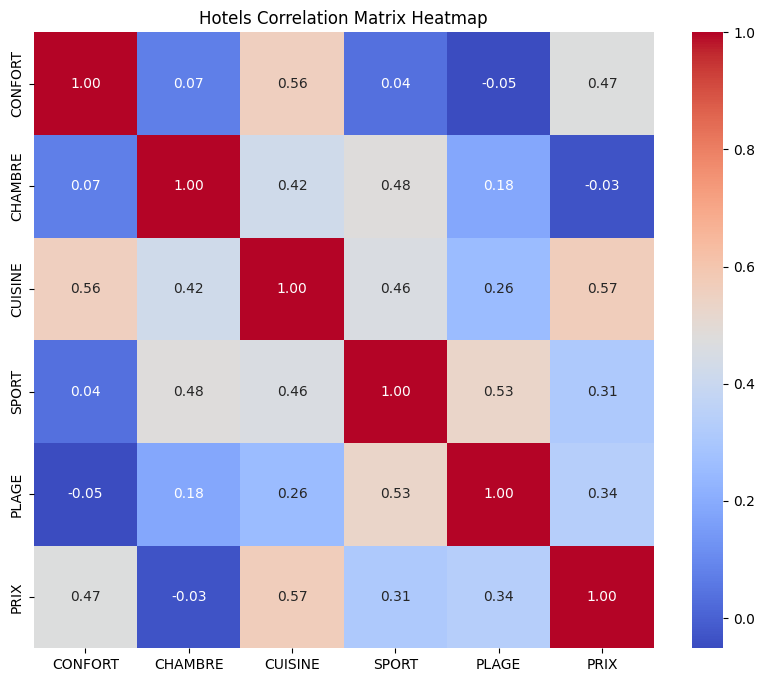

In [42]:
# 1. Use the correlation matrice and visualize with a heatmap
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Hotels Correlation Matrix Heatmap')

### 3. Preprocessing the Data
To perform clustering, the data must be centered and scaled:

1. First, convert the `DataFrame` object into a `numpy` array by using the `to_numpy()` method of the `DataFrame` class.

1. Next, use the `StandardScaler` class from `sklearn.preprocessing` to center and scale the data. Use the `fit()` and `transform()` methods to obtain the normalized data matrix.




In [43]:
# 1
df_np = data.to_numpy()

# 2
df_np = StandardScaler().fit_transform(df_np)

### 4. Visualizing the Data

Before clustering, it is useful to represent the data in 2 dimensions to check whether they have a specific natural structure and if any clusters visually appear.

1. Perform a PCA with 2 components using the `PCA` class from `sklearn.decomposition`. Compute the overall quality of the representation. 

2. Use the `transform()` method of the `PCA` class to obtain the principal components (coordinates of the observations on axes 0 and 1).

3.  Represent the observations on the first principal plane using the `scatter()` function from `matplotlib.pyplot`. For each point, it is useful to write the hotel name and the star rating with the `text()` function from `matplotlib.pyplot`. 

4. Do any obvious clusters appear visually?

Explained variance by PC1: 0.436
Explained variance by PC2: 0.236
Total variance explained with 2 components: 0.671


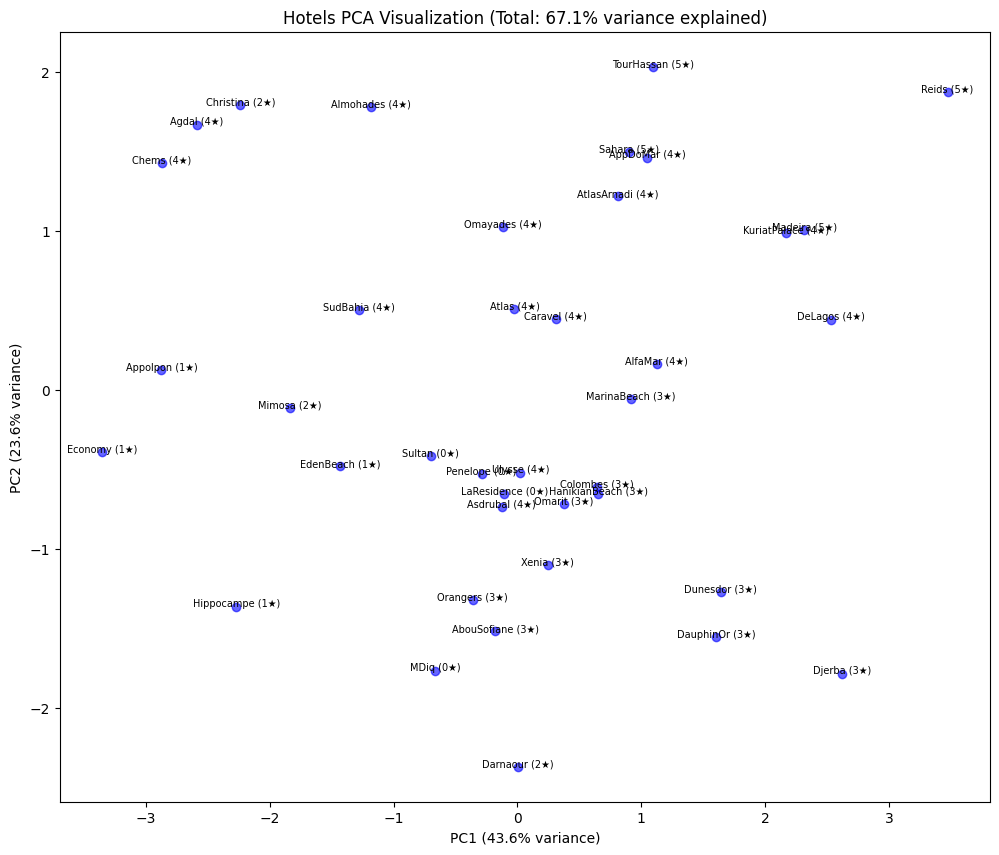

In [44]:
# 1
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(df_np)

# 2
explained_variance = pca.explained_variance_ratio_
total_variance_explained = np.sum(explained_variance)
print(f"Explained variance by PC1: {explained_variance[0]:.3f}")
print(f"Explained variance by PC2: {explained_variance[1]:.3f}")
print(f"Total variance explained with 2 components: {total_variance_explained:.3f}")

# 3
original_data = pd.read_csv('hotels.csv')
hotel_names = original_data['NOM']
hotel_stars = original_data['ETOILE']

plt.figure(figsize=(12, 10))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c='blue', alpha=0.6)

# Label with name and star
for i in range(len(pca_coords)):
    plt.text(
        pca_coords[i, 0], pca_coords[i, 1], 
        f'{hotel_names[i]} ({hotel_stars[i]}★)', 
        fontsize=7,
        ha='center'
    )

plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
plt.title(f'Hotels PCA Visualization (Total: {total_variance_explained:.1%} variance explained)')
plt.show()

# 4. The PCA visualization helps to identify patterns and clusters among hotels based on their features.


### 5. Agglomerative Hierarchical Clustering

1. To implement agglomerative hierarchical clustering in Python, we use the `scipy.cluster.hierarchy` module, mainly the functions `dendrogram`, `linkage`, and `fcluster`. Study these functions.

1. We will consider the Euclidean metric for calculating distances between points and different linkage methods for calculating distances between clusters: single, complete, average, centroid, and ward. 
    For each of these linkage methods:

    1. Perform the full agglomerative hierarchical clustering using the `linkage` function (with parameter `optimal_ordering=True` for better visualization of the results). This function returns a linkage matrix.

    1. Represent this linkage matrix as a dendrogram using the `dendrogram` function (with parameter `color_threshold=0` to obtain the full dendrogram).

1. Visually identify the linkage method that produces the best partitions (homogeneous and well-separated clusters).
    

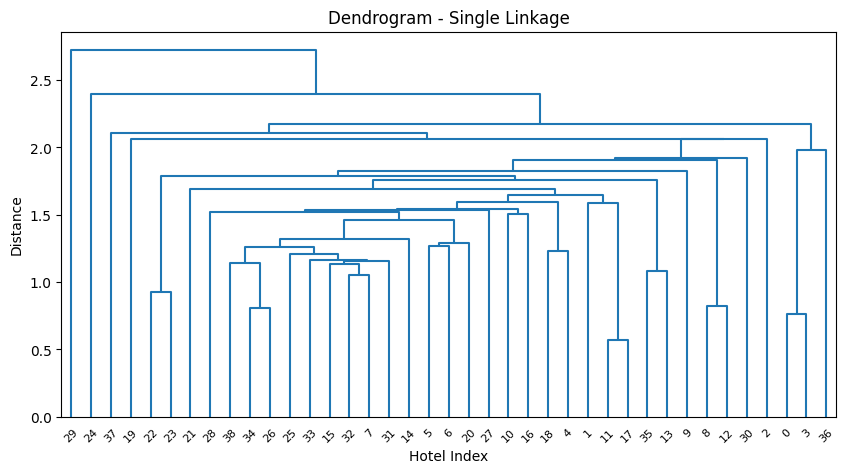

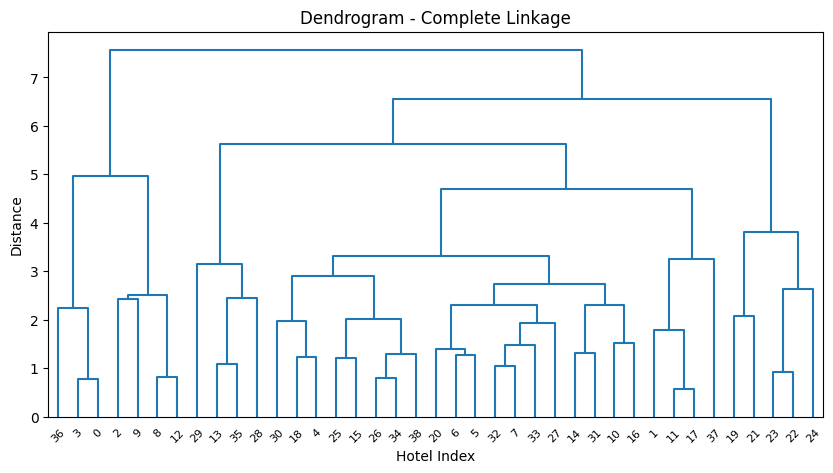

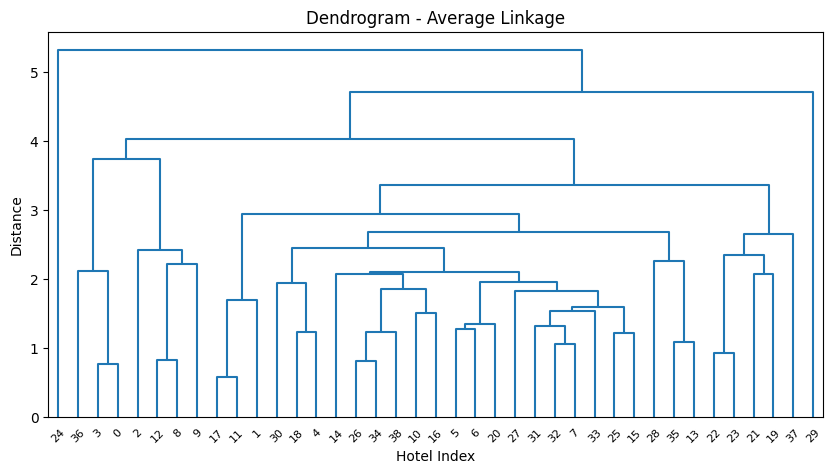

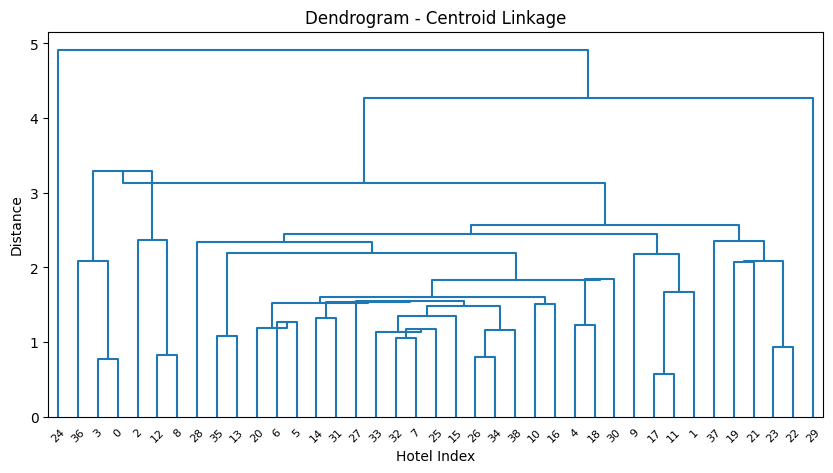

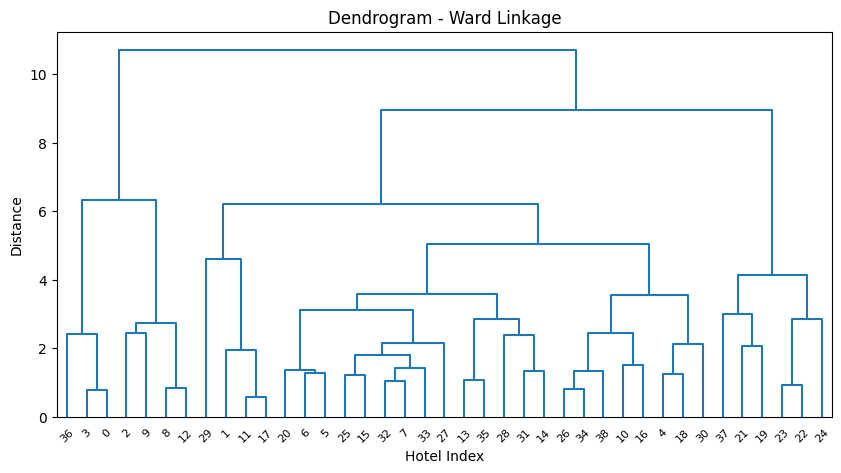

1. Single: Create elongated clusters
2. Complete: Create more compact and well distributed clusters
3. Average: Balance between single and complete
4. Centroid: Can produce inversions in the dendrogram
5. Ward: Minimize intra-cluster variance, usually gives good results

Answer: In my concept the average and ward methods produce clearer and more balanced cuts.


In [57]:
# 2. Create the linkage by each method
linkage_matrix_single = linkage(df_np, method='single', optimal_ordering=True)
linkage_matrix_complete = linkage(df_np, method='complete', optimal_ordering=True)
linkage_matrix_average = linkage(df_np, method='average', optimal_ordering=True)
linkage_matriz_centroid = linkage(df_np, method='centroid', optimal_ordering=True)
linkage_matrix_ward = linkage(df_np, method='ward', optimal_ordering=True)

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_single, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Single Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_complete, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Complete Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_average, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Average Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(linkage_matriz_centroid, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Centroid Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix_ward, color_threshold=0, leaf_font_size=8, orientation='top')
plt.title('Dendrogram - Ward Linkage')
plt.xlabel('Hotel Index')
plt.ylabel('Distance')
plt.show()

# 3. Compare the dendrograms by visual analysis
print('1. Single: Create elongated clusters')
print('2. Complete: Create more compact and well distributed clusters')
print('3. Average: Balance between single and complete')
print('4. Centroid: Can produce inversions in the dendrogram')
print('5. Ward: Minimize intra-cluster variance, usually gives good results')
print('\nAnswer: In my concept the average and ward methods produce clearer and more balanced cuts.')

### 6. Agglomerative Hierarchical Clustering (continued)

1. For the selected linkage method, propose a few (2 or 3) relevant values for the number $K$ of clusters.
    For each value of $K$:
    
    1. Determine on the dendrogram the required threshold (or height) $t$ to cut the tree. Display the clusters in color on the dendrogram by running the `dendrogram` function again with `color_threshold=t`.

    1. Perform clustering using the `fcluster` function with this threshold $t$ and the distance criterion (`criterion='distance'`). Print the result of the function, which is a vector containing, for each data point, the label (number) of its cluster.

    1. To evaluate the quality of the clustering, calculate the silhouette score using the `silhouette.score` function from the `sklearn.metrics` module. 

1. Compare the results and determine the best partition (according to silhouette score).

1. For this best partition, list the names and star ratings of the hotels in each cluster. To retrieve the indices of the hotels assigned to clusters, the simplest method is to use the `argsort` function from `numpy`: the returned indices correspond to the cluster labels sorted in ascending order.

1. For cluster visualization, color the points belonging to the same cluster with a specific color on the previous 2D representation obtained by PCA. Analyze the clustering result. 


### 7. K-Means

1. To implement the K-means algorithm in Python, we use the `KMeans` class from the `sklearn.cluster` module. Study this class:
- call parameters: `n_clusters`, `init`, and `n_init`,
- attributes: `labels_`, `inertia_`, and `cluster_centers_`,
- methods: `fit()`.

1. Apply the K-means algorithm for a number of clusters $K$ of your choice, first with a random initialization (`init='random'`) and a single run (`n_init=1`). Compute the inertia of the obtained partition using the `inertia_` attribute and the silhouette score using the `silhouette.score` function from the `sklearn.metrics` module. 

1. Run the algorithm a second time, compute again the inertia and the silhouette score, and compare the new partition with the previous one by calculating the Adjusted Rand Index (ARI) using the `adjusted_rand_score` function from the `sklearn.metrics` module.

1. Do the same with the `k-means++` initialization method and multiple runs (`n_init=10`). Comment on the stability of the K-means algorithm. 

1. Determine the optimal value of $K$ using the two methods seen in class: the elbow method and the silhouette method (you can vary $K$ from 2 to 10).

### 8. K-Means (continued)

1. For the optimal value of $K$, list the names and star ratings of the hotels in each cluster.

1. Visualize the clustering in 2D and analyze the clustering result. 

1. Check whether it is possible to automatically retrieve the classification of hotels based on their stars. To do this, apply the K-means method with $K=6$, since there are $6$ star categories (0 to 5), and examine the relationship between the star rating of the hotels and their clusters. To quantify the matching between the clustering result (given by the `labels_` attribute) and the star classification (given by the ETOILE column), you can use the Adjusted Rand Index.